In [16]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, detect_extrema_dot_motion
import pyreadr
import rdata
import json
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

# Model

In [2]:
def build_network(inputs, w_accumulator, w_speed, nActions=2, nNeurons=500, synapse=0.1, seed=0, ramp=1, threshold=0.5, speed=-0.1, relative=0,
        max_rates=nengo.dists.Uniform(60, 80), rA=1, save_w=False, weights_or_decoders="decoders"):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    net.config[nengo.Ensemble].max_rates = max_rates

    # references
    net.inputs = inputs
    net.seed = seed
    net.synapse = synapse
    net.nNeurons = nNeurons

    net.ramp = ramp
    net.threshold = threshold
    net.speed = speed
    net.relative = relative

    func_input = lambda t: net.inputs.sample(t)
    func_threshold = lambda t: net.threshold
    func_speed = lambda t: net.speed
    func_ramp = lambda x: net.synapse * net.ramp * x
    func_value = lambda x: [x[0]-x[1]*net.relative, x[1]-x[0]*net.relative]  # raw evidence vs relative advantage

    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0, 1)

    with net:
        # Inputs
        environment = nengo.Node(func_input)
        baseline_threshold = nengo.Node(func_threshold)
        speed_control = nengo.Node(func_speed)
        # Ensembles
        perception = nengo.Ensemble(nNeurons, nActions, seed=seed)
        accumulator = nengo.Ensemble(nNeurons, nActions, radius=rA, seed=seed)
        value = nengo.Ensemble(nNeurons, nActions, radius=net.threshold, seed=seed)
        boundary = nengo.Ensemble(nNeurons, 1, seed=seed)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos, seed=seed)
        action = nengo.networks.EnsembleArray(nNeurons, nActions, encoders=ePos, intercepts=iPos, seed=seed)
        # Connections
        nengo.Connection(environment, perception, seed=seed)  # external inputs
        nengo.Connection(perception, accumulator, synapse=net.synapse, function=func_ramp, seed=seed)  # send percepts to accumulator
        # recurrent cortical connection for accumulation
        if save_w:
            conn_accumulator = nengo.Connection(accumulator, accumulator, synapse=net.synapse, seed=seed)            
        elif weights_or_decoders=="decoders":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator, synapse=net.synapse, transform=w_accumulator, seed=seed)
        elif weights_or_decoders=="weights":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator.neurons, synapse=net.synapse, transform=w_accumulator, seed=seed)
        nengo.Connection(accumulator, value, function=func_value, seed=seed)  # compute value from evidence in accumulator
        nengo.Connection(value, action.input, seed=seed)
        nengo.Connection(baseline_threshold, gate, seed=seed)  # baseline activity for gate population
        nengo.Connection(speed_control, boundary, seed=seed)  # external inputs (from "cortex") sets decision threshold based on task instructions
        # corticostriatal white matter connection
        if save_w:
            conn_speed = nengo.Connection(boundary, gate, seed=seed)
        elif weights_or_decoders=="decoders":
            conn_speed = nengo.Connection(boundary.neurons, gate, transform=w_speed, seed=seed)
        elif weights_or_decoders=="weights":
            conn_speed = nengo.Connection(boundary.neurons, gate.neurons, transform=w_speed, seed=seed)
        nengo.Connection(gate, action.input, transform=-1*np.ones((nActions, 1)))  # inhibition via decision criteria
        # Probes
        net.pInputs = nengo.Probe(environment, synapse=None)
        net.pPerception = nengo.Probe(perception)
        net.pAccumulator = nengo.Probe(accumulator)
        net.pValue = nengo.Probe(value)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        net.accumulator = accumulator
        net.value = value
        net.boundary = boundary
        net.gate = gate
        net.conn_accumulator = conn_accumulator
        net.conn_speed = conn_speed
    return net

## Age Manipulation

In [3]:
def degrade_weights(net_young, pre_sim, degrade_accumulator, degrade_speed, seed=0, weights_or_decoders="weights"):
    young_accumulator = pre_sim.data[net_young.conn_accumulator].weights  # decoders
    young_speed = pre_sim.data[net_young.conn_speed].weights  # decoders
    old_accumulator = young_accumulator.copy()
    old_speed = young_speed.copy()
    rng = np.random.RandomState(seed=seed)

    if weights_or_decoders=="decoders":
        idx_accumulator = rng.choice(range(old_accumulator.shape[1]), size=int(degrade_accumulator*old_accumulator.shape[1]), replace=False)
        idx_speed = rng.choice(range(old_speed.shape[1]), size=int(degrade_speed*old_speed.shape[1]), replace=False)
        old_accumulator[:,idx_accumulator] = 0
        old_speed[:,idx_speed] = 0

    if weights_or_decoders=="weights":
        e_accumulator = pre_sim.data[net_young.accumulator].encoders
        e_speed = pre_sim.data[net_young.gate].encoders
        w_accumulator = e_accumulator @ young_accumulator
        w_speed = e_speed @ young_speed
        # print(e_accumulator.shape, old_accumulator.shape, w_accumulator.shape)
        flat_accumulator = w_accumulator.ravel().copy()
        flat_speed = w_speed.ravel().copy()
        idx_accumulator = rng.choice(range(flat_accumulator.shape[0]), size=int(degrade_accumulator*flat_accumulator.shape[0]), replace=False)
        idx_speed = rng.choice(range(flat_speed.shape[0]), size=int(degrade_speed*flat_speed.shape[0]), replace=False)
        flat_accumulator[idx_accumulator] = 0
        flat_speed[idx_speed] = 0
        old_accumulator = flat_accumulator.reshape(w_accumulator.shape)
        old_speed = flat_speed.reshape(w_speed.shape)
        # print(np.sum(w_accumulator), np.sum(old_accumulator))
        # print(np.sum(w_speed), np.sum(old_speed))

    return old_accumulator, old_speed

## Simulation loop

In [31]:
def simulate(
        coherence=0.1,
        degrade_accumulator=0.0,
        degrade_speed=0.0,
        weights_or_decoders="decoders",
        emphases=['accuracy', 'neutral', 'speed'],
        ages = ['young', 'old'],
        emphases_weighting=[0, 0.3, 1.0],
        ramp=1.0,
        threshold=0.4,
        speed=-0.3,
        relative=0.0,
        sigma=0.1,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(80, 100),
        rA=1.0,
        trials=10,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.03,
        tmax=3,
        pid=None,
        name="forstmann_default"):
    
    columns = ['type', 'age', 'pid', 'trial', 'emphasis', 'error', "RT"]
    dfs = []
    for e, emphasis in enumerate(emphases):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        S = emphases_weighting[e] * speed
        print(f"emphases {emphasis}")
        for trial in range(trials):
            if 'young' in ages:
                net_young = build_network(inputs, None, None, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                          max_rates=max_rates, ramp=ramp, threshold=threshold, speed=S, relative=relative,
                                          save_w=True, weights_or_decoders=weights_or_decoders)
                sim_young = nengo.Simulator(net_young, progress_bar=False)
                # simulate the "young" network
                choice = None
                while choice==None:
                    sim_young.run(dt)
                    if np.any(sim_young.data[net_young.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim_young.data[net_young.pAction][-1,:])
                        RT = sim_young.trange()[-1]
                    if sim_young.trange()[-1] > tmax:
                        choice = np.argmax(sim_young.data[net_young.pValue][-1,:])
                        RT = sim_young.trange()[-1]
                error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', 'young', pid, trial, emphasis, error, RT]], columns=columns))

            if 'old' in ages:
                # effectively "age" the model from a functional, young model to an impaired "elderly" model
                old_accumulator, old_speed = degrade_weights(net_young, sim_young, degrade_accumulator, degrade_speed, trial, weights_or_decoders)
                net_old = build_network(inputs, old_accumulator, old_speed,
                                        nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, speed=S, relative=relative,
                                        save_w=False, weights_or_decoders=weights_or_decoders)
                sim_old = nengo.Simulator(net_old, progress_bar=False)
    
                # simulate the "old" network
                choice = None
                while choice==None:
                    sim_old.run(dt)
                    if np.any(sim_old.data[net_old.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim_old.data[net_old.pAction][-1,:])
                        RT = sim_old.trange()[-1]
                    if sim_old.trange()[-1] > tmax:
                        choice = np.argmax(sim_old.data[net_old.pValue][-1,:])
                        RT = sim_old.trange()[-1]
                error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', 'old', pid, trial, emphasis, error, RT]], columns=columns))
    
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [5]:
def simulate_extrema(
        coherence=0.1,
        emphases=['accuracy', 'neutral', 'speed'],
        ages = ['young'],
        thresholds=[0.4, 0.4],
        nd_mean=0.0,
        nd_sigma=0.0,
        sigma=0.3,
        nActions=2,
        trials=10,
        perception_seed=0,
        network_seed=0,
        dt_sample=0.01,
        tmax=1.5,
        name="forstmann_extrema"):
    
    rng = np.random.RandomState(seed=network_seed)
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'error', "RT"]
    dfs = []
    for e, emphasis in enumerate(emphases):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        threshold = thresholds[e]
        for trial in range(trials):
            choice, RT = detect_extrema_dot_motion(inputs, threshold,
                tiebreaker="random", tmax=tmax, seed=network_seed)
            ndt = rng.normal(nd_mean, nd_sigma)
            ndt = np.max([0, ndt])
            RT += ndt  # add non-decision time to model's RT
            RT = np.min([tmax, RT])
            error = 0 if choice==inputs.correct else 100
            dfs.append(pd.DataFrame([['extrema', 'young', trial, emphasis, trial, error, RT]], columns=columns))
 
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plot

In [6]:
def plot_young_old(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    order = ['speed', 'neutral', 'accuracy']

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row', figsize=((7, 5)))
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='RT', hue='age', order=order,
                 palette=palette[:2], ax=axes[0][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='RT', hue='age', order=order,
                 palette=palette[:2], ax=axes[0][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=order,
                 palette=palette[:2], ax=axes[0][2])
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='error', hue='age', order=order,
                 palette=palette[:2], ax=axes[1][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='error', hue='age', order=order,
                 palette=palette[:2], ax=axes[1][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=order,
                 palette=palette[:2], ax=axes[1][2])
    axes[0][0].set(ylabel="Response Time (s)", title="Human")
    axes[0][1].set(title="Model")
    axes[0][2].set(title="Extrema")
    axes[1][0].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[0][0].get_legend().remove()
    axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_young_old.svg")
    fig.savefig(f"plots/forstmann_young_old.png", dpi=600)

In [7]:
def plot_RTs(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    order = ['speed', 'neutral', 'accuracy']
    bins = np.arange(0.2, 1.25, 0.05)

    fig = sns.FacetGrid(combined, col='age', hue='type', row="emphasis", row_order=order,
                        hue_order=['human', 'model', 'extrema'], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs.svg")
    fig.savefig(f"plots/forstmann_RTs.png", dpi=600)

# Empirical

In [8]:
def format_forstmann_young():
    raw = pyreadr.read_r("data/forstmann.rda")['forstmann']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subjects'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subjects==@pid")
        trial = 0
        for _, row in data.iterrows():
            # accuracy = 100 if row['R']==row['S'] else 0
            error = 0 if row['R']==row['S'] else 100
            emphasis = row['E']
            RT = row['rt']
            df = pd.DataFrame([['human', 'young', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
            trial += 1
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_young.pkl")

In [9]:
# format_forstmann_young()

In [10]:
def format_forstmann_old():
    parsed = rdata.parser.parse_file("data/brown.RData")
    raw = rdata.conversion.convert(parsed)['rawdata']['old']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subj'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subj==@pid")
        for _, row in data.iterrows():
            error = 0 if row['correct']==1 else 100
            trial = row['trnr']
            if row['cue'] == 'SN': emphasis = 'speed'
            if row['cue'] == 'AK': emphasis = 'accuracy'
            if row['cue'] == 'NE': emphasis = 'neutral'
            RT = row['RT'] / 1000
            df = pd.DataFrame([['human', 'old', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_old.pkl")

In [38]:
# format_forstmann_old()

In [11]:
def combine_forstmann():
    young = pd.read_pickle(f"data/forstmann2011_young.pkl")
    old = pd.read_pickle(f"data/forstmann2011_old.pkl")
    forstmann = pd.concat([young, old], ignore_index=True)
    forstmann.to_pickle("data/forstmann2011.pkl")

In [12]:
# combine_forstmann()

In [13]:
def plot_empirical(empfile):
    emp = pd.read_pickle(f"data/{empfile}.pkl")

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7, 5)))
    sns.barplot(data=emp, x='emphasis', y='RT', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[0])
    sns.barplot(data=emp, x='emphasis', y='error', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel="Emphasis", ylabel="Response Time (s)")
    # axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_empirical.svg")
    fig.savefig(f"plots/forstmann_empirical.png", dpi=600)

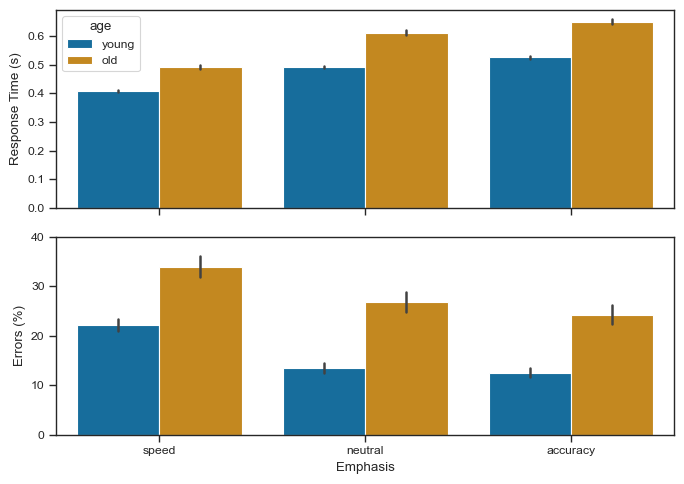

In [42]:
plot_empirical("forstmann2011")

In [43]:
emp = pd.read_pickle(f"data/forstmann2011.pkl")
print(emp.query("age=='young'")['pid'].unique())
print(emp.query("age=='old'")['pid'].unique())

['as1t' 'bd6t' 'bl1t' 'hsft' 'hsgt' 'kd6t' 'kd9t' 'kmat' 'ku4t' 'na1t'
 'rmbt' 'rt2t' 'rt3t' 'rt5t' 'scat' 'ta5t' 'vf1t' 'zk1t']
['br4t' 'he5t' 'kf1t' 'kj1t' 'km1t' 'rw2t' 'sd9t' 'si7t' 'su8t' 'sw7t'
 'th8t' 'vb8t' 'vc7t']


In [21]:
def plot_RTs_individual(simfile, empfile, bins=np.arange(0.0, 1.25, 0.05)):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    combined = pd.concat([sim, emp], ignore_index=True)
    order = ['speed', 'neutral', 'accuracy']
    fig = sns.FacetGrid(combined, col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs_individual.svg")
    fig.savefig(f"plots/forstmann_RTs_individual.png", dpi=600)

In [19]:
# plot_RTs_individual("forstmann2011", bins=np.arange(0.0, 1.3, 0.1))

# Simulations

In [9]:
trials = 300
coherence = 0.08
dt_sample = 0.1
emphases_weighting = [0.0, 0.35, 1.0]
ramp = 1.56
relative = 0.06
sigma = 0.285
speed = -0.059
threshold = 0.33
tmax = 1.5

degrade_accumulator = 0.05
degrade_speed = 0.1
weights_or_decoders = "decoders"
ages = ['young', 'old']

simulate(
    ages=ages,
    coherence=coherence,
    trials=trials,
    sigma=sigma,
    threshold=threshold,
    ramp=ramp,
    dt_sample=dt_sample,
    degrade_accumulator=degrade_accumulator,
    degrade_speed=degrade_speed,
    speed=speed,
    relative=relative,
    weights_or_decoders=weights_or_decoders,
    tmax=tmax,
    name="june19")

# may23b  {'coherence': 0.1, 'dt_sample': 0.048, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.73, 'relative': 0.27, 'sigma': 0.49, 'speed': -0.071, 'threshold': 0.33}
# may24 {'coherence': 0.15, 'dt_sample': 0.053, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.94, 'relative': 0.09, 'sigma': 0.5, 'speed': -0.087, 'threshold': 0.42}
# may27 {'coherence': 0.1, 'dt_sample': 0.096, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.69, 'relative': 0.14, 'sigma': 0.37, 'speed': -0.071, 'threshold': 0.35}
# may28  {'coherence': 0.1, 'dt_sample': 0.01, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.62, 'relative': 0.73, 'sigma': 0.3, 'speed': -0.032, 'threshold': 0.14}
# may29  {'coherence': 0.15, 'dt_sample': 0.077, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.57, 'relative': 0.39, 'sigma': 0.299, 'speed': -0.059, 'threshold': 0.27}
# may30  {'coherence': 0.15, 'dt_sample': 0.083, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.95, 'relative': 0.2, 'sigma': 0.393, 'speed': -0.09, 'threshold': 0.42}
# june5  {'coherence': 0.1, 'dt_sample': 0.087, 'e1': 0.0, 'e2': 0.2, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.75, 'relative': 0.570, 'sigma': 0.19, 'speed': -0.045, 'threshold': 0.21}
# june19 {'coherence': 0.08, 'dt_sample': 0.1, 'e1': 0.0, 'e2': 0.35, 'e3': 1.0, 'ramp': 1.56, 'relative': 0.06, 'sigma': 0.285, 'speed': -0.059, 'threshold': 0.33}

emphases accuracy
emphases neutral
emphases speed


### All pids

In [36]:
trials = 200
tmax = 1.5
degrade_accumulator = 0.05
degrade_speed = 0.1
ages = ['young', 'old']
label = "june21"

emp = pd.read_pickle(f"data/forstmann2011.pkl").query("age=='young'")
for pid in ['as1t']:  # emp['pid'].unique():
    with open(f"data/forstmann_optimized_params_{label}.json") as f:
        params = json.load(f)[pid]
    simulate(
        ages=ages,
        coherence=params['coherence'],
        trials=trials,
        sigma=params['sigma'],
        threshold=params['threshold'],
        ramp=params['ramp'],
        dt_sample=params['dt_sample'],
        degrade_accumulator=degrade_accumulator,
        degrade_speed=degrade_speed,
        speed=params['speed'],
        relative=params['relative'],
        emphases_weighting = [0.0, params['e2'], 1.0],
        weights_or_decoders="decoders",
        tmax=tmax,
        pid=pid,
        name=f"forstmann_{pid}_{label}")

dfs = []
for pid in ['as1t', 'bd6t']:  # emp['pid'].unique():
    dfs.append(pd.read_pickle(f"data/forstmann_{pid}_{label}.pkl"))
simulated = pd.concat(dfs, ignore_index=True)
simulated.to_pickle(f"data/forstmann_{label}.pkl")

emphases accuracy
emphases neutral
emphases speed


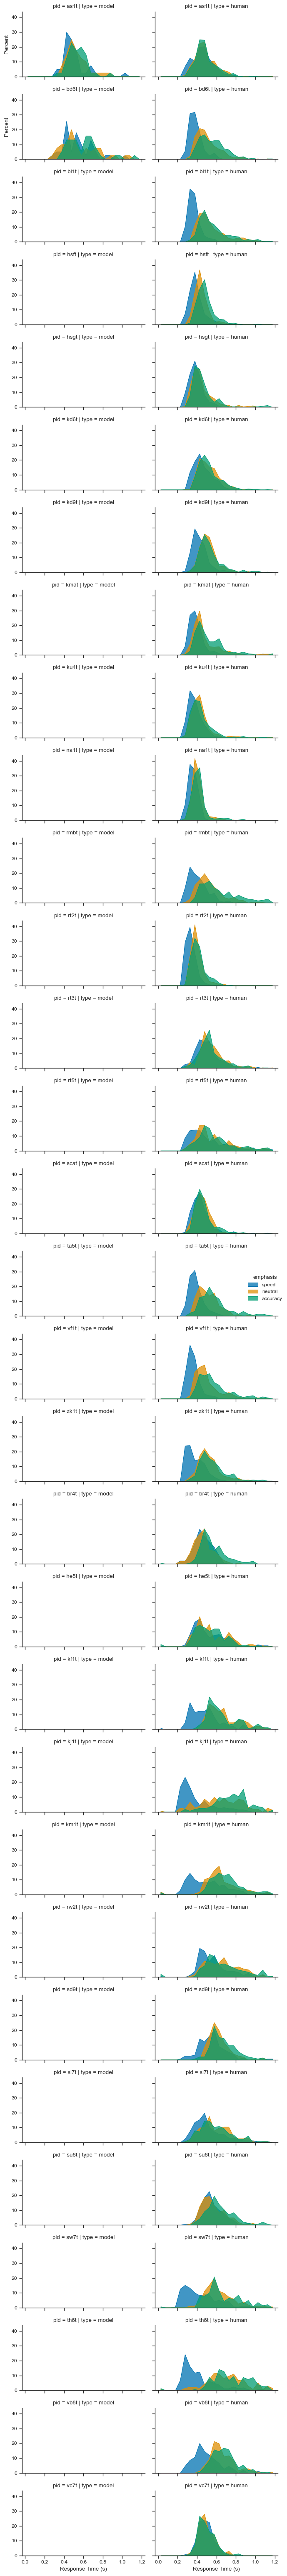

In [34]:
plot_RTs_individual("forstmann_june21", "forstmann2011")

In [18]:
simulate_extrema(
        trials=300,
        coherence=0.2,
        emphases=['accuracy', 'neutral', 'speed'],
        ages = ['young'],
        thresholds=[0.977, 0.948, 0.863],
        nd_mean=0.3,
        nd_sigma=0.015,
        sigma=0.283,
        nActions=2,
        dt_sample=0.032,
        tmax=1.5,
        name="may31_extrema3")

# may28  {'dt_sample': 0.01, 'nd_mean': 0.362, 'nd_sigma': 0.051, 'sigma': 0.3, 'threshold1': 1.037, 'threshold3': 0.844}
# may30  {'dt_sample': 0.06, 'nd_mean': 0.393, 'nd_sigma': 0.057, 'sigma': 0.232, 'threshold1': 0.732, 'threshold2': 0.705, 'threshold3': 0.224}
# may31  {'dt_sample': 0.056, 'nd_mean': 0.381, 'nd_sigma': 0.053, 'sigma': 0.275, 'threshold1': 0.818, 'threshold2': 0.777, 'threshold3': 0.604}
# may31 3 {'dt_sample': 0.032, 'nd_mean': 0.3, 'nd_sigma': 0.015, 'sigma': 0.283, 'threshold1': 0.977, 'threshold2': 0.948, 'threshold3': 0.863}


# Results

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_2328\243924863.py:13: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=order,
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_2328\243924863.py:19: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=order,


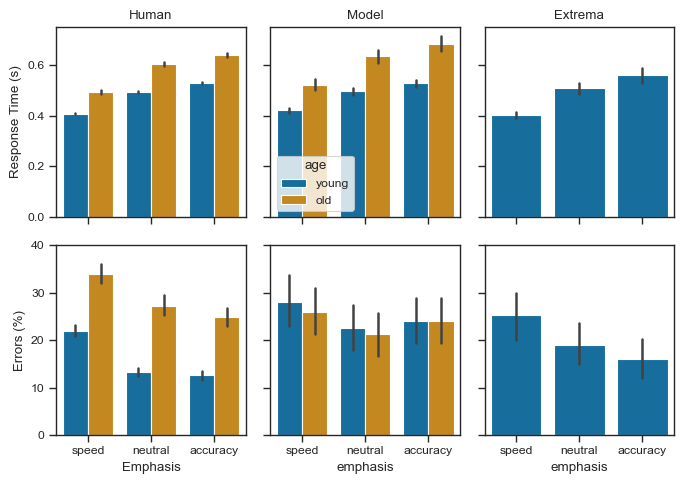

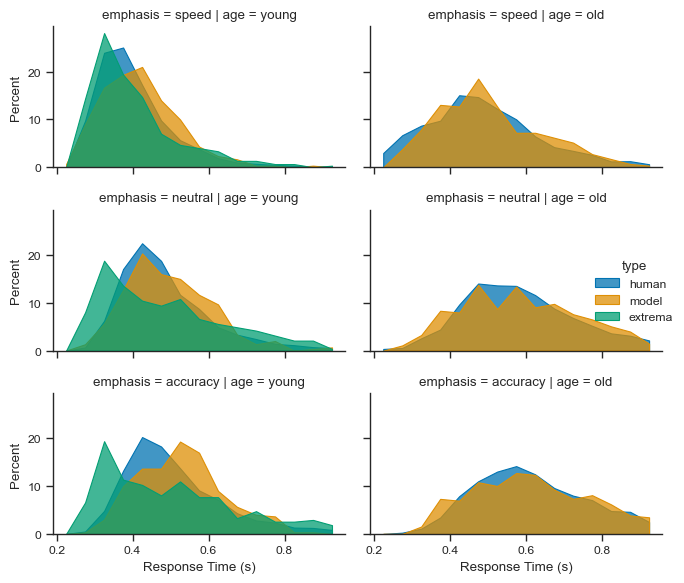

In [64]:
plot_young_old("may30_decoders", "forstmann2011", "may31_extrema3")
plot_RTs("may30_decoders", "forstmann2011", "may31_extrema3")

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_2328\243924863.py:13: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=order,
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_2328\243924863.py:19: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=order,


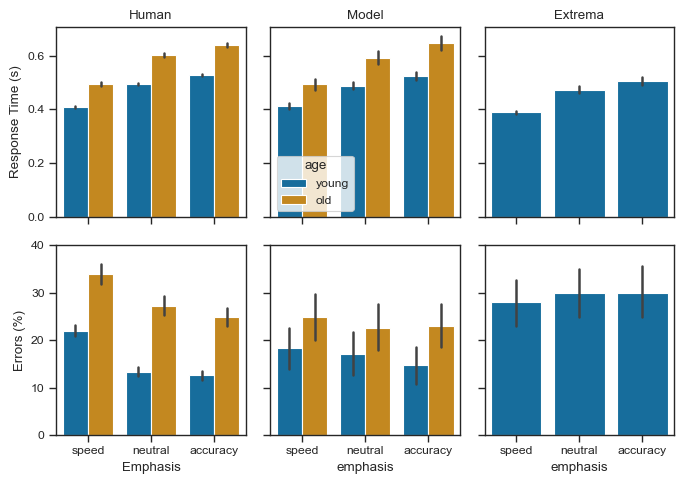

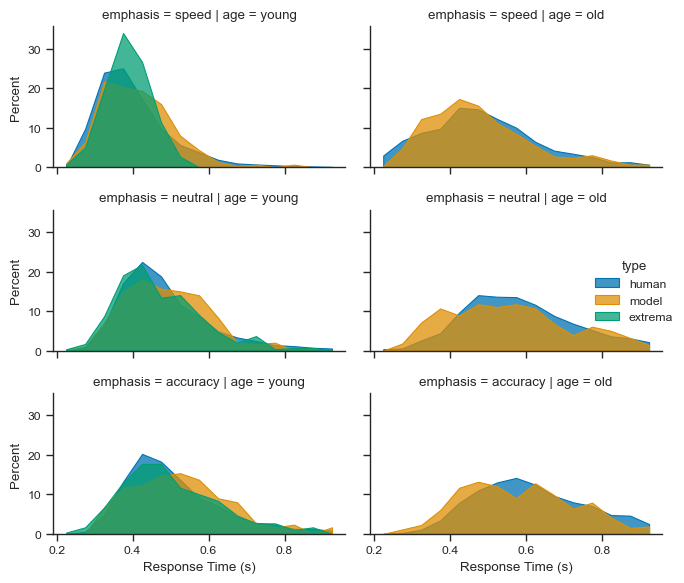

In [63]:
plot_young_old("may29_decoders", "forstmann2011", "may30_extrema")
plot_RTs("may29_decoders", "forstmann2011", "may30_extrema")

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_2328\243924863.py:13: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=order,
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_2328\243924863.py:19: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=order,


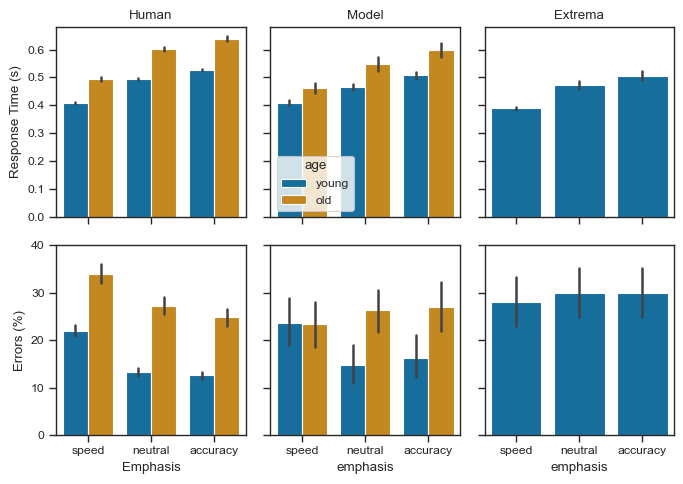

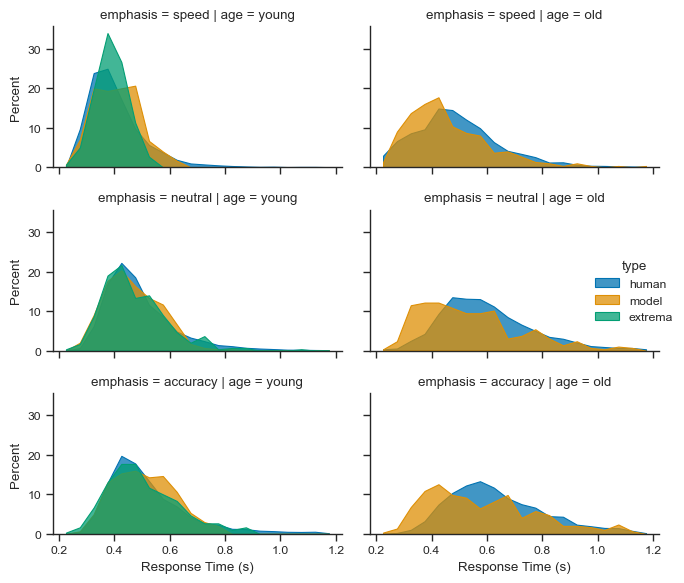

In [70]:
plot_young_old("june5", "forstmann2011", "may30_extrema")
plot_RTs("june5", "forstmann2011", "may30_extrema")

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_9804\243924863.py:13: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=order,
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_9804\243924863.py:19: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=order,


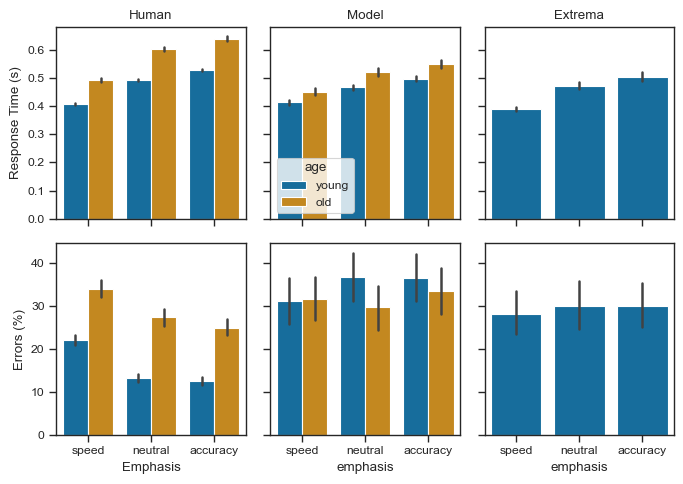

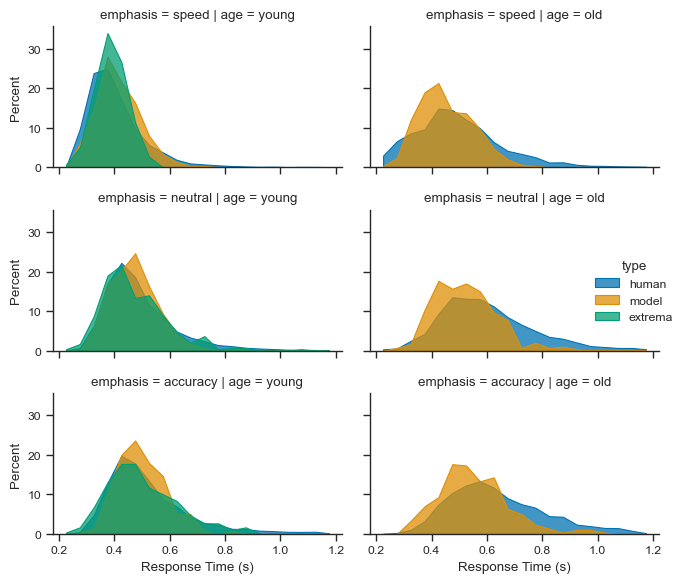

In [10]:
plot_young_old("june19", "forstmann2011", "may30_extrema")
plot_RTs("june19", "forstmann2011", "may30_extrema")

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_15024\243924863.py:13: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=order,
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_15024\243924863.py:19: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=order,


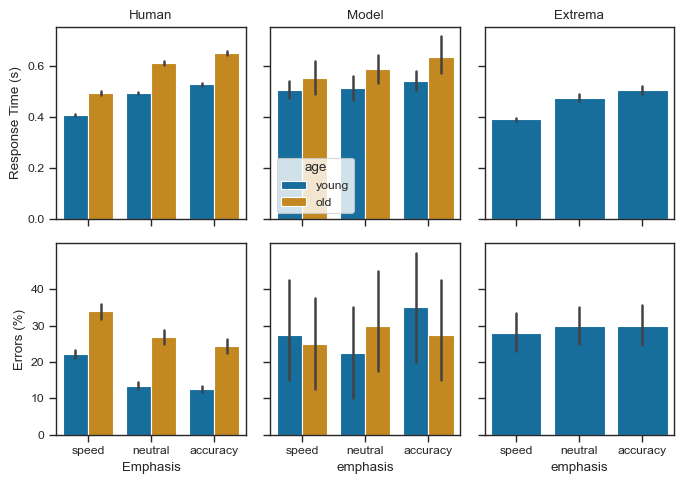

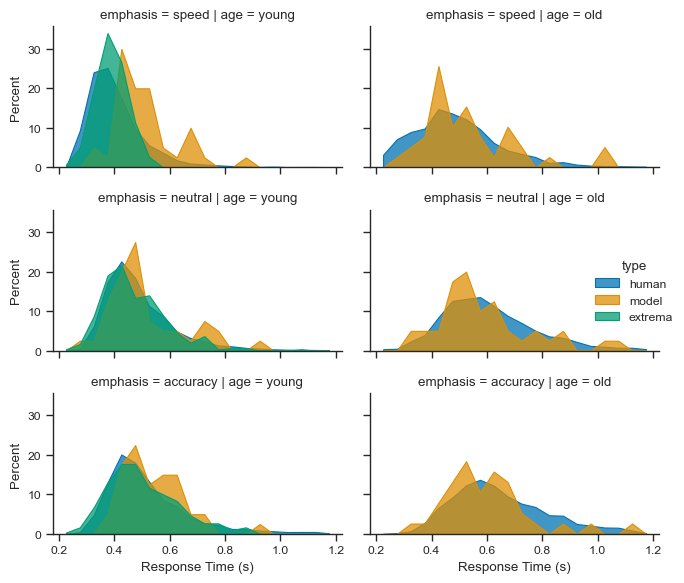

In [35]:
plot_young_old("forstmann_june21", "forstmann2011", "may30_extrema")
plot_RTs("forstmann_june21", "forstmann2011", "may30_extrema")